Supercode

In [1]:
import catboost as cb
import glob
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import xgboost as xgb

from scikeras.wrappers import KerasRegressor
from scipy.stats import uniform, randint
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set(style = "whitegrid", context = "notebook", font_scale = 1.1)

start_time = time.time()

In [2]:
input_folder = r"C:\Users\Hi\My Works\My Py Scripts\Git Repos\48_March-achine-learning-mania-2025\Input"
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

dataframes = {}
for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]
    try:
        # Using 'latin-1' encoding to avoid Unicode issues
        dataframes[key] = pd.read_csv(file, low_memory=False, encoding="latin-1")
        print(f"Loaded {key} with shape {dataframes[key].shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")
print("\nAll CSV files loaded automatically.")

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")

Loaded Cities with shape (502, 3)
Loaded Conferences with shape (51, 2)
Loaded MConferenceTourneyGames with shape (6491, 5)
Loaded MGameCities with shape (84509, 6)
Loaded MMasseyOrdinals with shape (5435396, 5)
Loaded MNCAATourneyCompactResults with shape (2518, 8)
Loaded MNCAATourneyDetailedResults with shape (1382, 34)
Loaded MNCAATourneySeedRoundSlots with shape (776, 5)
Loaded MNCAATourneySeeds with shape (2558, 3)
Loaded MNCAATourneySlots with shape (2519, 4)
Loaded MRegularSeasonCompactResults with shape (190771, 8)
Loaded MRegularSeasonDetailedResults with shape (116723, 34)
Loaded MSeasons with shape (41, 6)
Loaded MSecondaryTourneyCompactResults with shape (1809, 9)
Loaded MSecondaryTourneyTeams with shape (1836, 3)
Loaded MTeamCoaches with shape (13533, 5)
Loaded MTeamConferences with shape (13388, 3)
Loaded MTeams with shape (380, 4)
Loaded MTeamSpellings with shape (1177, 2)
Loaded SampleSubmissionStage1 with shape (507108, 2)
Loaded SampleSubmissionStage2 with shape (1314

In [3]:
def initialize_elo(team_ids, start_elo=1500):
    return {tid: start_elo for tid in team_ids}

def update_elo(elo_dict, teamA, teamB, scoreA, scoreB, k=20):
    ra = elo_dict[teamA]
    rb = elo_dict[teamB]
    ea = 1.0 / (1 + 10 ** ((rb - ra) / 400))
    sa = 1 if scoreA > scoreB else 0
    sb = 1 - sa
    elo_dict[teamA] = ra + k * (sa - ea)
    elo_dict[teamB] = rb + k * (sb - (1 - ea))

def compute_elo(df_games, teams_df):
    df_sorted = df_games.sort_values(by=['Season','DayNum'])
    team_ids = teams_df['TeamID'].unique()
    elo_dict = initialize_elo(team_ids)
    for idx, row in df_sorted.iterrows():
        update_elo(elo_dict, row['WTeamID'], row['LTeamID'], row['WScore'], row['LScore'])
    return elo_dict

# Men’s Elo using MTeams and MRegularSeasonDetailedResults
df_MTeams = dataframes['MTeams']
df_MReg = dataframes['MRegularSeasonDetailedResults'].copy()
elo_m = compute_elo(df_MReg, df_MTeams)
print("Computed Elo ratings for men's data.")

# Women’s Elo using WTeams and WRegularSeasonDetailedResults
df_WTeams = dataframes['WTeams']
df_WReg = dataframes['WRegularSeasonDetailedResults'].copy()
elo_w = compute_elo(df_WReg, df_WTeams)
print("Computed Elo ratings for women's data.")

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")

Computed Elo ratings for men's data.
Computed Elo ratings for women's data.

Total Execution Time: 18.51 seconds


In [4]:
def prepare_training_data(df, elo_dict):
    elo_diffs = []
    margins = []
    seasons = []
    for idx, row in df.iterrows():
        diff = elo_dict.get(row['WTeamID'], 1500) - elo_dict.get(row['LTeamID'], 1500)
        elo_diffs.append(diff)
        margins.append(row['WScore'] - row['LScore'])
        seasons.append(row['Season'])
    return pd.DataFrame({'Season': seasons, 'EloDiff': elo_diffs, 'Margin': margins})

# Prepare men's training data
train_m_all = prepare_training_data(df_MReg, elo_m)
print("Men's training data shape:", train_m_all.shape)

# Prepare women's training data
train_w_all = prepare_training_data(df_WReg, elo_w)
print("Women's training data shape:", train_w_all.shape)

end_time = time.time()
print(f"\nTotal Execution Time: {end_time - start_time:.2f} seconds")

Men's training data shape: (116723, 3)
Women's training data shape: (79639, 3)

Total Execution Time: 33.47 seconds


In [5]:
# For Men: use all seasons except 2024 for training, 2024 for validation.
train_m_train = train_m_all[train_m_all['Season'] != 2024].reset_index(drop=True)
val_m = train_m_all[train_m_all['Season'] == 2024].reset_index(drop=True)
print("Men's training split shape:", train_m_train.shape, "Validation split shape:", val_m.shape)

# For Women: likewise split (assuming season 2024 exists in women’s data)
train_w_train = train_w_all[train_w_all['Season'] != 2024].reset_index(drop=True)
val_w = train_w_all[train_w_all['Season'] == 2024].reset_index(drop=True)
print("Women's training split shape:", train_w_train.shape, "Validation split shape:", val_w.shape)

Men's training split shape: (111116, 3) Validation split shape: (5607, 3)
Women's training split shape: (74225, 3) Validation split shape: (5414, 3)


In [6]:
def margin_to_probability(margin, scale=10.0):
    """Convert predicted margin to win probability via logistic transform."""
    return 1.0 / (1 + 10 ** (-margin / scale))

def predict_match(season, team1, team2, elo_men, elo_women, model_m, model_w):
    """
    For a given matchup, use:
      - men's model if both team IDs < 2000,
      - women's model if both team IDs >= 3000,
      - else default to 0.5.
    """
    if team1 < 2000 and team2 < 2000:
        e1 = elo_men.get(team1, 1500)
        e2 = elo_men.get(team2, 1500)
        diff = e1 - e2
        margin_pred = model_m.predict(pd.DataFrame({'EloDiff': [diff]}))[0]
        p = margin_to_probability(margin_pred)
    elif team1 >= 3000 and team2 >= 3000:
        e1 = elo_women.get(team1, 1500)
        e2 = elo_women.get(team2, 1500)
        diff = e1 - e2
        margin_pred = model_w.predict(pd.DataFrame({'EloDiff': [diff]}))[0]
        p = margin_to_probability(margin_pred)
    else:
        p = 0.5
    return p

In [7]:
# For the DNN, we define a callable builder function.
def build_dnn_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

from scipy.stats import uniform, randint

models_grid = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge": {
        "model": Ridge(),
        "params": {"alpha": uniform(0.1, 10)}
    },
    "Lasso": {
        "model": Lasso(max_iter=5000),
        "params": {"alpha": uniform(0.001, 1)}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {"max_depth": randint(1, 10), "min_samples_split": randint(2, 10)}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {"n_estimators": randint(50, 200), "max_depth": randint(1, 10)}
    },
    "ExtraTrees": {
        "model": ExtraTreesRegressor(random_state=42),
        "params": {"n_estimators": randint(50, 200), "max_depth": randint(1, 10)}
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {"n_estimators": randint(50, 200), "learning_rate": uniform(0.01, 0.3), "max_depth": randint(1, 10)}
    },
    # "SVR": {
    #     "model": SVR(),
    #     "params": {"C": uniform(0.1, 10), "epsilon": uniform(0.01, 1)}
    # },
    "XGBoost": {
        "model": xgb.XGBRegressor(tree_method="hist", device="cuda", random_state=42),
        "params": {"n_estimators": randint(50, 200), "learning_rate": uniform(0.01, 0.3), "max_depth": randint(1, 10)}
    },
    "LightGBM": {
        "model": lgb.LGBMRegressor(device="gpu", random_state=42),
        "params": {"n_estimators": randint(50, 200), "learning_rate": uniform(0.01, 0.3), "num_leaves": randint(20, 50)}
    },
    "CatBoost": {
        "model": cb.CatBoostRegressor(task_type="GPU", verbose=0, random_state=42),
        "params": {"iterations": randint(50, 200), "learning_rate": uniform(0.01, 0.3), "depth": randint(3, 10)}
    },
    "DNN": {
        "model": KerasRegressor(model=build_dnn_model, verbose=0),
        "params": {
            "model__layers": [[Dense(32, activation='relu'),
                               Dropout(0.2),
                               Dense(1)]],
            "batch_size": randint(16, 64),
            "epochs": randint(10, 50)
        }
    }
}

In [8]:
def tune_and_evaluate(model_obj, param_dist, X_train, y_train, X_val, y_val):
    rs = RandomizedSearchCV(model_obj, param_distributions=param_dist, 
                              n_iter=10, cv=5, scoring="neg_mean_squared_error", random_state=42, error_score='raise')
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    y_pred = best_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    # For evaluation we convert the predicted margin to probability assuming the winning team wins (prob=1)
    prob_pred = margin_to_probability(y_pred, scale=10.0)
    brier = np.mean((prob_pred - 1)**2)  # using a dummy ground truth of 1
    return best_model, rmse, brier

# Prepare men's training data
X_train_m = train_m_train[['EloDiff']]
y_train_m = train_m_train['Margin']
X_val_m = val_m[['EloDiff']]
y_val_m = val_m['Margin']

men_results = {}
men_best_models = {}
print("Tuning Men's models:")
for name, model_info in models_grid.items():
    print(f"Tuning Men's {name} ...")
    try:
        best_model, rmse, brier = tune_and_evaluate(model_info["model"], model_info["params"],
                                                    X_train_m, y_train_m, X_val_m, y_val_m)
        men_results[name] = {"rmse": rmse, "brier": brier}
        men_best_models[name] = best_model
        print(f"Men's {name}: RMSE = {rmse:.4f}, Brier = {brier:.4f}\n")
    except Exception as e:
        print(f"Men's {name} tuning failed: {e}\n")

    end_time = time.time()
    print(f"Total Execution Time: {end_time - start_time:.2f} seconds\n")

Tuning Men's models:
Tuning Men's LinearRegression ...
Men's LinearRegression: RMSE = 8.2919, Brier = 0.0051

Total Execution Time: 33.74 seconds

Tuning Men's Ridge ...
Men's Ridge: RMSE = 8.2919, Brier = 0.0051

Total Execution Time: 34.11 seconds

Tuning Men's Lasso ...
Men's Lasso: RMSE = 8.2927, Brier = 0.0051

Total Execution Time: 34.55 seconds

Tuning Men's DecisionTree ...
Men's DecisionTree: RMSE = 8.1258, Brier = 0.0052

Total Execution Time: 40.46 seconds

Tuning Men's RandomForest ...
Men's RandomForest: RMSE = 8.1218, Brier = 0.0052

Total Execution Time: 728.47 seconds

Tuning Men's ExtraTrees ...
Men's ExtraTrees: RMSE = 8.1333, Brier = 0.0050

Total Execution Time: 788.49 seconds

Tuning Men's GradientBoosting ...
Men's GradientBoosting: RMSE = 8.1966, Brier = 0.0049

Total Execution Time: 1667.05 seconds

Tuning Men's XGBoost ...
Men's XGBoost: RMSE = 8.1254, Brier = 0.0051

Total Execution Time: 1685.77 seconds

Tuning Men's LightGBM ...
[LightGBM] [Info] This is the

In [9]:
# Prepare women's training data
X_train_w = train_w_train[['EloDiff']]
y_train_w = train_w_train['Margin']
X_val_w = val_w[['EloDiff']]
y_val_w = val_w['Margin']

women_results = {}
women_best_models = {}
print("Tuning Women's models:")
for name, model_info in models_grid.items():
    print(f"Tuning Women's {name} ...")
    try:
        best_model, rmse, brier = tune_and_evaluate(model_info["model"], model_info["params"],
                                                    X_train_w, y_train_w, X_val_w, y_val_w)
        women_results[name] = {"rmse": rmse, "brier": brier}
        women_best_models[name] = best_model
        print(f"Women's {name}: RMSE = {rmse:.4f}, Brier = {brier:.4f}\n")
    except Exception as e:
        print(f"Women's {name} tuning failed: {e}\n")

    end_time = time.time()
    print(f"Total Execution Time: {end_time - start_time:.2f} seconds\n")

Tuning Women's models:
Tuning Women's LinearRegression ...
Women's LinearRegression: RMSE = 10.3049, Brier = 0.0020

Total Execution Time: 1779.43 seconds

Tuning Women's Ridge ...
Women's Ridge: RMSE = 10.3049, Brier = 0.0020

Total Execution Time: 1779.79 seconds

Tuning Women's Lasso ...
Women's Lasso: RMSE = 10.3058, Brier = 0.0020

Total Execution Time: 1780.19 seconds

Tuning Women's DecisionTree ...
Women's DecisionTree: RMSE = 9.8394, Brier = 0.0021

Total Execution Time: 1784.39 seconds

Tuning Women's RandomForest ...
Women's RandomForest: RMSE = 9.8544, Brier = 0.0021

Total Execution Time: 2255.67 seconds

Tuning Women's ExtraTrees ...
Women's ExtraTrees: RMSE = 9.8786, Brier = 0.0020

Total Execution Time: 2297.98 seconds

Tuning Women's GradientBoosting ...
Women's GradientBoosting: RMSE = 9.8780, Brier = 0.0022

Total Execution Time: 2878.66 seconds

Tuning Women's XGBoost ...
Women's XGBoost: RMSE = 9.8458, Brier = 0.0021

Total Execution Time: 2898.83 seconds

Tuning W

Women's CatBoost: RMSE = 9.8770, Brier = 0.0020

Total Execution Time: 2987.18 seconds

Tuning Women's DNN ...
Women's DNN tuning failed: object of type 'NoneType' has no len()

Total Execution Time: 2987.21 seconds



In [10]:
print("Men's Model Results:")
for name, res in men_results.items():
    print(f"{name}: RMSE = {res['rmse']:.4f}, Brier = {res['brier']:.4f}")

print("\nWomen's Model Results:")
for name, res in women_results.items():
    print(f"{name}: RMSE = {res['rmse']:.4f}, Brier = {res['brier']:.4f}")

# For tree-based models (men's), show feature importance (only one feature, 'EloDiff'):
tree_models = ["DecisionTree", "RandomForest", "ExtraTrees", "GradientBoosting", "XGBoost", "LightGBM", "CatBoost"]
print("\nMen's Tree-based Model Feature Importances (EloDiff):")
for name in tree_models:
    model = men_best_models.get(name)
    if model is not None and hasattr(model, "feature_importances_"):
        print(f"{name} importance: {model.feature_importances_}")

    end_time = time.time()
    print(f"Total Execution Time: {end_time - start_time:.2f} seconds\n")

Men's Model Results:
LinearRegression: RMSE = 8.2919, Brier = 0.0051
Ridge: RMSE = 8.2919, Brier = 0.0051
Lasso: RMSE = 8.2927, Brier = 0.0051
DecisionTree: RMSE = 8.1258, Brier = 0.0052
RandomForest: RMSE = 8.1218, Brier = 0.0052
ExtraTrees: RMSE = 8.1333, Brier = 0.0050
GradientBoosting: RMSE = 8.1966, Brier = 0.0049
XGBoost: RMSE = 8.1254, Brier = 0.0051
LightGBM: RMSE = 8.1264, Brier = 0.0051
CatBoost: RMSE = 8.1368, Brier = 0.0051

Women's Model Results:
LinearRegression: RMSE = 10.3049, Brier = 0.0020
Ridge: RMSE = 10.3049, Brier = 0.0020
Lasso: RMSE = 10.3058, Brier = 0.0020
DecisionTree: RMSE = 9.8394, Brier = 0.0021
RandomForest: RMSE = 9.8544, Brier = 0.0021
ExtraTrees: RMSE = 9.8786, Brier = 0.0020
GradientBoosting: RMSE = 9.8780, Brier = 0.0022
XGBoost: RMSE = 9.8458, Brier = 0.0021
LightGBM: RMSE = 9.8724, Brier = 0.0021
CatBoost: RMSE = 9.8770, Brier = 0.0020

Men's Tree-based Model Feature Importances (EloDiff):
DecisionTree importance: [1.]
Total Execution Time: 2987.23

In [11]:
# Load sample submission file and parse the ID into Season, Team1, and Team2.
df_sub = dataframes['SampleSubmissionStage2'].copy()
def parse_id(match_id):
    season, t1, t2 = match_id.split('_')
    return int(season), int(t1), int(t2)
df_sub['Season'] = df_sub['ID'].apply(lambda x: parse_id(x)[0])
df_sub['Team1'] = df_sub['ID'].apply(lambda x: parse_id(x)[1])
df_sub['Team2'] = df_sub['ID'].apply(lambda x: parse_id(x)[2])
print("Sample submission file prepared:")
print(df_sub.head())

# Create a folder for submissions.
submission_folder = "model_submissions"
os.makedirs(submission_folder, exist_ok=True)

# Loop through candidate models.
for name in models_grid.keys():
    preds = []
    for idx, row in df_sub.iterrows():
        s = row['Season']
        t1 = row['Team1']
        t2 = row['Team2']
        # If both teams are men's (IDs <2000) use men's model; if both are women's (IDs >=3000) use women's model.
        if t1 < 2000 and t2 < 2000:
            model_used = men_best_models.get(name)
            if model_used is not None:
                diff = elo_m.get(t1, 1500) - elo_m.get(t2, 1500)
                margin_pred = model_used.predict(pd.DataFrame({'EloDiff': [diff]}))[0]
                p = margin_to_probability(margin_pred)
            else:
                p = 0.5
        elif t1 >= 3000 and t2 >= 3000:
            model_used = women_best_models.get(name)
            if model_used is not None:
                diff = elo_w.get(t1, 1500) - elo_w.get(t2, 1500)
                margin_pred = model_used.predict(pd.DataFrame({'EloDiff': [diff]}))[0]
                p = margin_to_probability(margin_pred)
            else:
                p = 0.5
        else:
            p = 0.5  # Fallback for mixed matchups.
        preds.append(p)
    df_sub['Pred'] = preds
    sub_filename = os.path.join(submission_folder, f"submission_{name}_both.csv")
    df_sub[['ID', 'Pred']].to_csv(sub_filename, index=False)
    print(f"Saved submission file for {name}: {sub_filename}")

    end_time = time.time()
    print(f"Total Execution Time: {end_time - start_time:.2f} seconds\n")

Sample submission file prepared:
               ID  Pred  Season  Team1  Team2
0  2025_1101_1102   0.5    2025   1101   1102
1  2025_1101_1103   0.5    2025   1101   1103
2  2025_1101_1104   0.5    2025   1101   1104
3  2025_1101_1105   0.5    2025   1101   1105
4  2025_1101_1106   0.5    2025   1101   1106
Saved submission file for LinearRegression: model_submissions\submission_LinearRegression_both.csv
Total Execution Time: 3141.76 seconds

Saved submission file for Ridge: model_submissions\submission_Ridge_both.csv
Total Execution Time: 3294.11 seconds

Saved submission file for Lasso: model_submissions\submission_Lasso_both.csv
Total Execution Time: 3449.16 seconds

Saved submission file for DecisionTree: model_submissions\submission_DecisionTree_both.csv
Total Execution Time: 3609.12 seconds

Saved submission file for RandomForest: model_submissions\submission_RandomForest_both.csv
Total Execution Time: 4987.55 seconds

Saved submission file for ExtraTrees: model_submissions\submi

In [12]:
print("\nAll models have been tuned and submission files have been created for both men and women.")
print("Men's Model Results:")
for name, res in men_results.items():
    print(f"{name}: RMSE = {res['rmse']:.4f}, Brier = {res['brier']:.4f}")
print("\nWomen's Model Results:")
for name, res in women_results.items():
    print(f"{name}: RMSE = {res['rmse']:.4f}, Brier = {res['brier']:.4f}")
print(f"\nTotal Execution Time: {time.time()-start_time:.2f} seconds")


All models have been tuned and submission files have been created for both men and women.
Men's Model Results:
LinearRegression: RMSE = 8.2919, Brier = 0.0051
Ridge: RMSE = 8.2919, Brier = 0.0051
Lasso: RMSE = 8.2927, Brier = 0.0051
DecisionTree: RMSE = 8.1258, Brier = 0.0052
RandomForest: RMSE = 8.1218, Brier = 0.0052
ExtraTrees: RMSE = 8.1333, Brier = 0.0050
GradientBoosting: RMSE = 8.1966, Brier = 0.0049
XGBoost: RMSE = 8.1254, Brier = 0.0051
LightGBM: RMSE = 8.1264, Brier = 0.0051
CatBoost: RMSE = 8.1368, Brier = 0.0051

Women's Model Results:
LinearRegression: RMSE = 10.3049, Brier = 0.0020
Ridge: RMSE = 10.3049, Brier = 0.0020
Lasso: RMSE = 10.3058, Brier = 0.0020
DecisionTree: RMSE = 9.8394, Brier = 0.0021
RandomForest: RMSE = 9.8544, Brier = 0.0021
ExtraTrees: RMSE = 9.8786, Brier = 0.0020
GradientBoosting: RMSE = 9.8780, Brier = 0.0022
XGBoost: RMSE = 9.8458, Brier = 0.0021
LightGBM: RMSE = 9.8724, Brier = 0.0021
CatBoost: RMSE = 9.8770, Brier = 0.0020

Total Execution Time: 

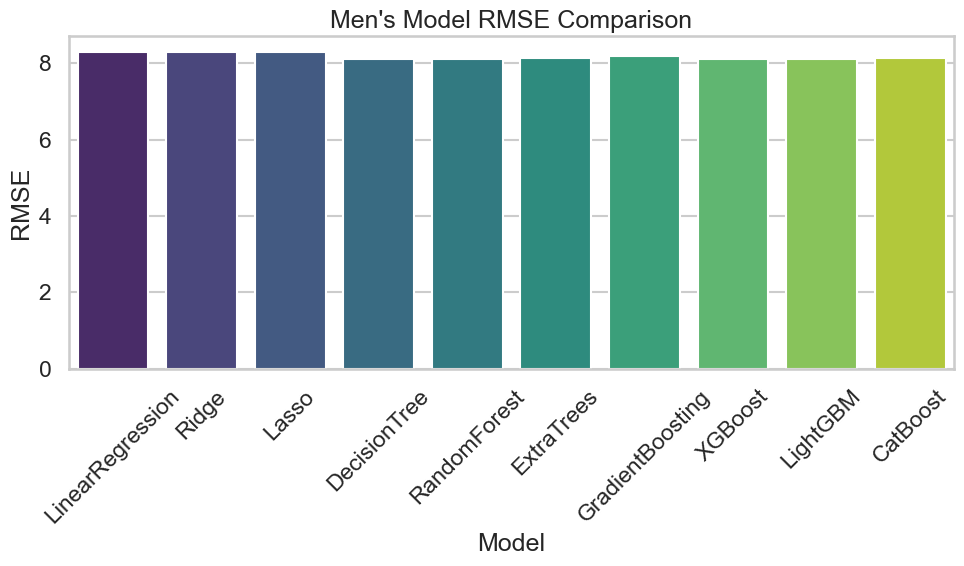

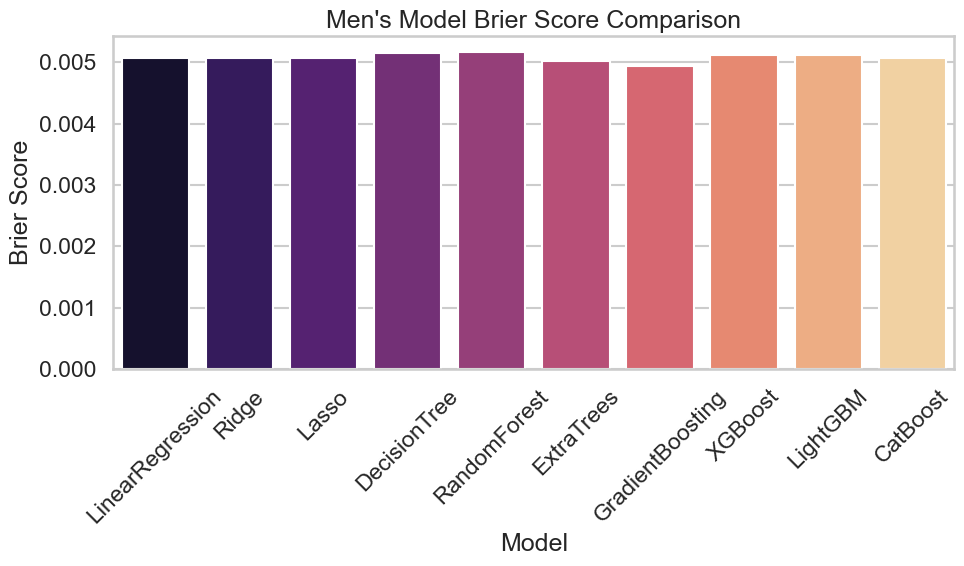

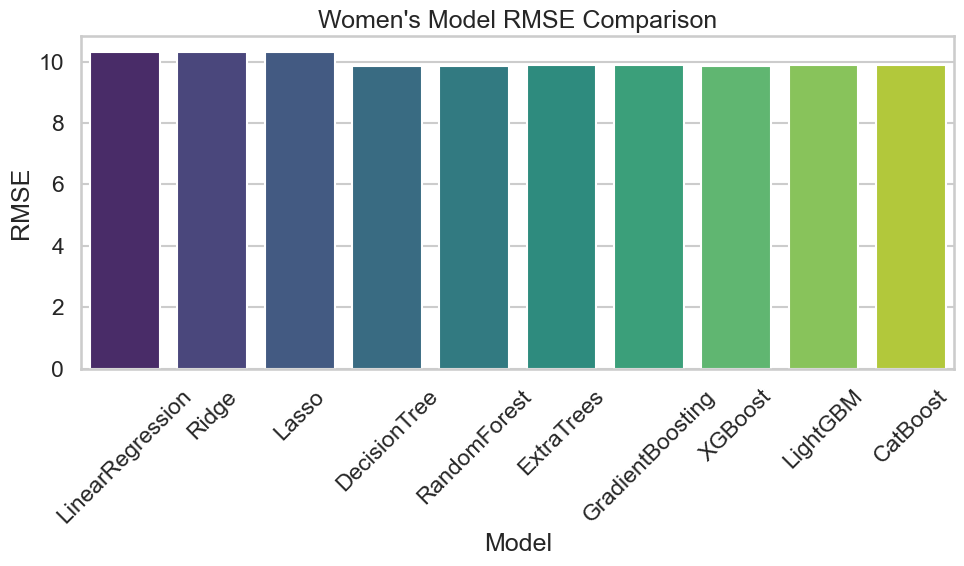

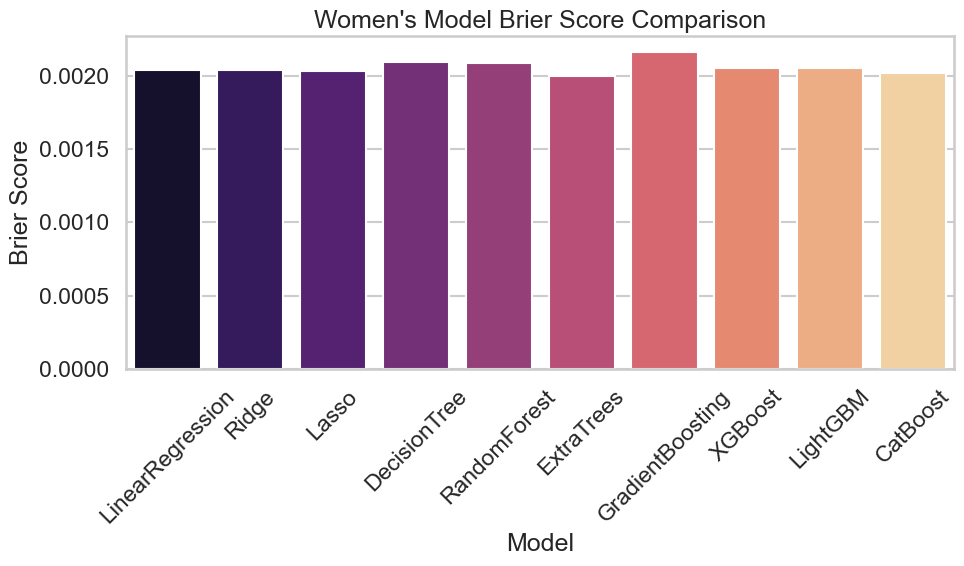

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Convert the results dictionaries to DataFrames
men_df = pd.DataFrame(men_results).T.reset_index().rename(columns={'index': 'Model'})
women_df = pd.DataFrame(women_results).T.reset_index().rename(columns={'index': 'Model'})

# Set the visualization style
sns.set(style="whitegrid", context="talk")

# Plot Men's RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='rmse', data=men_df, palette="viridis")
plt.title("Men's Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Men's Brier Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='brier', data=men_df, palette="magma")
plt.title("Men's Model Brier Score Comparison")
plt.ylabel("Brier Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Women's RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='rmse', data=women_df, palette="viridis")
plt.title("Women's Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Women's Brier Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='brier', data=women_df, palette="magma")
plt.title("Women's Model Brier Score Comparison")
plt.ylabel("Brier Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()